# Multiple Linear Regression for CIFAR-10 Dataset

In [56]:
import torch
import torchvision
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

n_epochs = 10
batch_size_train = 128
batch_size_test = 1000
learning_rate = 0.0001#1e-3
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Checking GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# CIFAR-10 dataset is part of torchvision
## Divide CIFAR-10 into training, validation and test sets
## Use DataLoader iterator for loading data in batches

In [57]:
# Source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

CIFAR10_training = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#train_indices = range(0, 48000)
#val_indices = range(48000, 60000)
#CIFAR10_training_set = Subset(CIFAR10_training,train_indices)
#CIFAR10_validation_set = Subset(CIFAR10_training,val_indices)

# create a training and a validation set
CIFAR10_training_set, CIFAR10_validation_set = random_split(CIFAR10_training, [45000, 5000])

# CIFAR-10 test set
CIFAR10_test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(CIFAR10_training_set,
                                           batch_size=batch_size_train,
                                           shuffle=True, num_workers=2)

validation_loader = torch.utils.data.DataLoader(CIFAR10_validation_set,
                                                batch_size=batch_size_train,
                                                shuffle=True, num_workers=2)


test_loader = torch.utils.data.DataLoader(CIFAR10_test_set,
                                          batch_size=batch_size_test,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Check DataLoader

In [58]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 3, 32, 32])
torch.Size([1000])


## Also, make sure to display some images

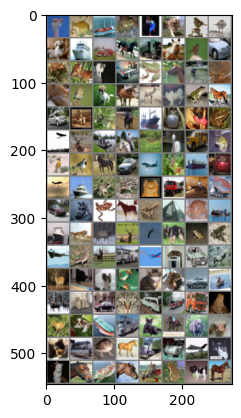

 bird  frog  ship  frog


In [59]:
# functions to show an image: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [60]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [61]:
# Multiple Linear regression
class MultipleLinearRegression(nn.Module):
    def __init__(self):
        super(MultipleLinearRegression, self).__init__()
        self.fc = nn.Linear(3*32*32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [62]:
multi_linear_model = MultipleLinearRegression().to(device)
optimizer = optim.Adam(multi_linear_model.parameters(), lr=learning_rate,weight_decay=0.001)
one_hot = one_hot = torch.nn.functional.one_hot

In [63]:
def train(epoch):
  multi_linear_model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)

    optimizer.zero_grad()
    output = multi_linear_model(data)

    loss_fn = nn.CrossEntropyLoss()
    temploss = loss_fn(output, target)
    l1_lambda = 0.0001
    l1_norm = sum(p.abs().sum() for p in multi_linear_model.parameters())
    loss = temploss + l1_lambda * l1_norm

    #loss = F.mse_loss(output, one_hot(target,num_classes=10).float())
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))


In [64]:
def validation():
  multi_linear_model.eval()
  validation_loss = 0
  correct = 0
  with torch.no_grad(): # notice the use of no_grad
    for data, target in validation_loader:
      data = data.to(device)
      target = target.to(device)
      output = multi_linear_model(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      validation_loss += F.mse_loss(output, one_hot(target,num_classes=10).float(), size_average=False).item()
  validation_loss /= len(validation_loader.dataset)
  print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(validation_loss, correct, len(validation_loader.dataset), 100. * correct / len(validation_loader.dataset)))

In [65]:
def test():
  multi_linear_model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = multi_linear_model(data)
      test_loss += F.mse_loss(output, one_hot(target,num_classes=10).float(), size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [ ]:
validation()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  validation()
test()


Validation set: Avg. loss: 1.8920, Accuracy: 531/5000 (11%)

Train Epoch: 1 [0/45000 (0%)]	Loss: 2.373676
Train Epoch: 1 [12800/45000 (28%)]	Loss: 1.798079
Train Epoch: 1 [25600/45000 (57%)]	Loss: 1.879131
Train Epoch: 1 [38400/45000 (85%)]	Loss: 1.730878

Validation set: Avg. loss: 12.0915, Accuracy: 1889/5000 (38%)

Train Epoch: 2 [0/45000 (0%)]	Loss: 1.764102
Train Epoch: 2 [12800/45000 (28%)]	Loss: 2.007964
Train Epoch: 2 [25600/45000 (57%)]	Loss: 1.936200
Train Epoch: 2 [38400/45000 (85%)]	Loss: 1.845228

Validation set: Avg. loss: 13.6509, Accuracy: 1945/5000 (39%)

Train Epoch: 3 [0/45000 (0%)]	Loss: 1.943598
Train Epoch: 3 [12800/45000 (28%)]	Loss: 1.897238
Train Epoch: 3 [25600/45000 (57%)]	Loss: 1.752458
Train Epoch: 3 [38400/45000 (85%)]	Loss: 1.677834

Validation set: Avg. loss: 14.3475, Accuracy: 1981/5000 (40%)

Train Epoch: 4 [0/45000 (0%)]	Loss: 1.946904
Train Epoch: 4 [12800/45000 (28%)]	Loss: 1.716205
Train Epoch: 4 [25600/45000 (57%)]	Loss: 1.680630
Train Epoch: 4 [